In [1]:
import os

import numpy as np
import pandas as pd
from scipy import signal, stats
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns
import joypy

from config import USERIDS

In [58]:
FULL_DIR = "C:/.coding/pnplab/friends-family/src/data/original/DailyEMA/"
#DATA_DIR = "./data/friends-family/"
DATA_DIR = FULL_DIR
EMA = "DailyEMA"
USERID = "fa10-01-24"

In [60]:
def _get_feature(feature, userid):
    # if userid is not specified, get the file containing all users
    try:
        feature = pd.read_csv(DATA_DIR + f"/{feature}_{userid}.csv", index_col=False)
    except:
        print(f"{feature} file missing for {userid}")
        feature = pd.DataFrame(columns=["timestamp", "userid"])
    
    feature.timestamp = pd.to_datetime(feature.timestamp)
    feature = feature.set_index("timestamp")
    feature = feature.sort_index()
    return feature

In [61]:
ema = _get_feature(EMA, USERID)
ema = ema.sort_values("ema_date").drop_duplicates("ema_date", keep="last")
ema["ema_date"] = pd.to_datetime(ema["ema_date"])
ema = ema.set_index("ema_date")
ema = ema.drop(columns=["userid"])
ema.head()

,happy,stress,productive,eat_healthy,sleep_h,social_h
ema_date,,,,,,
2010-11-12,5,3,5,5,9,0
2010-11-13,5,2,2,6,7,4
2010-11-14,6,2,3,5,8,0
2010-11-15,5,4,5,3,7,3
2010-11-16,5,5,5,3,7,0


In [62]:
def fill_missing_datetimeindex(df):
    date_range = pd.date_range(start=df.index[0], end=df.index[-1])
    missing_idx = date_range.difference(df.index)
    print("number of daily survey missing between first and last surveys: ", missing_idx.shape[0])
    return df.append(pd.DataFrame(index=missing_idx))

In [63]:
ema = fill_missing_datetimeindex(ema)

number of daily survey missing between first and last surveys:  1


In [7]:
def event_by_weekday(df):
    day_count = df.groupby(df.index.weekday).agg(["mean", "median", "skew", pd.Series.mode])
    day_count.plot(xlabel=["Monday", "Tuesday", "Wednesday", "Thurday", "Friday", "Saturday", "Sunday"], kind="bar")
    print("count", df.groupby(df.index.weekday).agg("count"))
    return day_count

In [8]:
def event_if_weekend(df):
    df["is_weekend"] = np.where(df.index.weekday > 3, 1, 0).copy() # includes Friday as part of weekend
    day_count = df.groupby(df.is_weekend).agg(["mean", "median", "skew", pd.Series.mode])
    day_count.plot(xlabel=["Monday", "Tuesday", "Wednesday", "Thurday", "Friday", "Saturday", "Sunday"], kind="bar")
    print("count", df.groupby(df.is_weekend).agg("count"))
    return day_count

count    social_h
0        27
1        27
2        27
3        26
4        28
5        28
6        27


social_h                      
       mean median      skew mode
0  0.370370    0.0  2.739837  0.0
1  0.148148    0.0  5.196152  0.0
2  0.222222    0.0  4.046378  0.0
3  0.423077    0.0  2.642529  0.0
4  1.214286    0.0  0.902903  0.0
5  2.250000    4.0 -0.281506  4.0
6  1.222222    0.0  0.914134  0.0

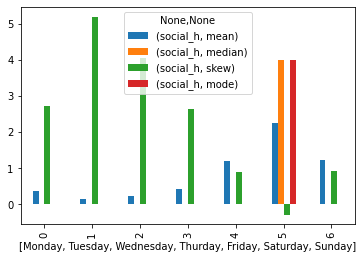

In [64]:
event_by_weekday(ema[["social_h"]])

count             social_h
is_weekend          
0                107
1                 83


<ipython-input-8-27708c1b6ad5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["is_weekend"] = np.where(df.index.weekday > 3, 1, 0).copy() # includes Friday as part of weekend


social_h                      
                mean median      skew mode
is_weekend                                
0           0.289720    0.0  3.235062  0.0
1           1.566265    0.0  0.452350  0.0

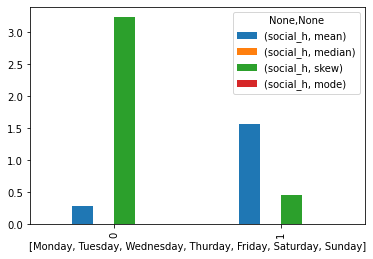

In [65]:
event_if_weekend(ema[["social_h"]])

# Visualizing time series

## Raw data

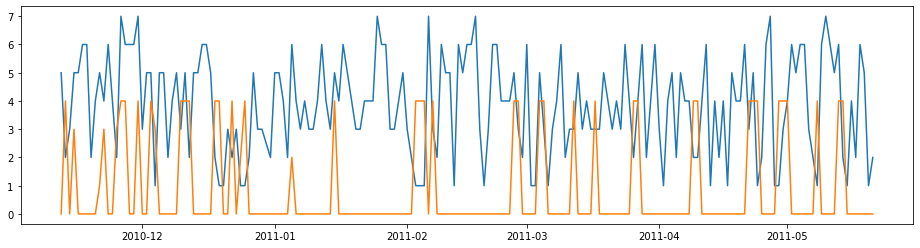

In [66]:
plt.figure(figsize=(16, 4))
plt.plot(ema["productive"])
plt.plot(ema["social_h"])
plt.show()

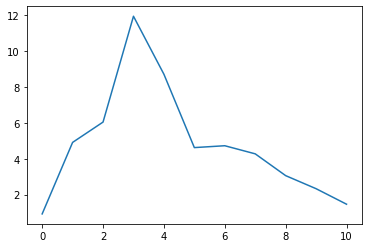

In [67]:
f, Pxx = signal.welch(ema["social_h"].fillna(method="ffill"), nperseg=21, noverlap=7, detrend="linear", scaling="density")
plt.plot(Pxx)

## Raw data is non stationary
i.e., the mean and the standard deviation vary over time

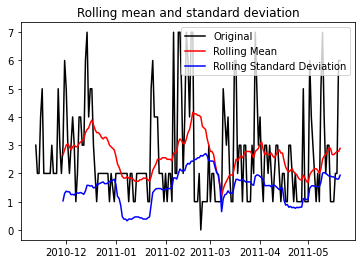

In [68]:
rmean=ema["stress"].rolling(window=18).mean()
rstd=ema["stress"].rolling(window=18).std()
orig=plt.plot(ema["stress"], color='black',label='Original')
mean= plt.plot(rmean , color='red',label='Rolling Mean')
std=plt.plot(rstd,color='blue',label = 'Rolling Standard Deviation')
plt.legend(loc='best')
plt.title("Rolling mean and standard deviation")
plt.show(block=False)

## standardized data

In [69]:
ema_std = ema.dropna().apply(stats.zscore, axis=0)

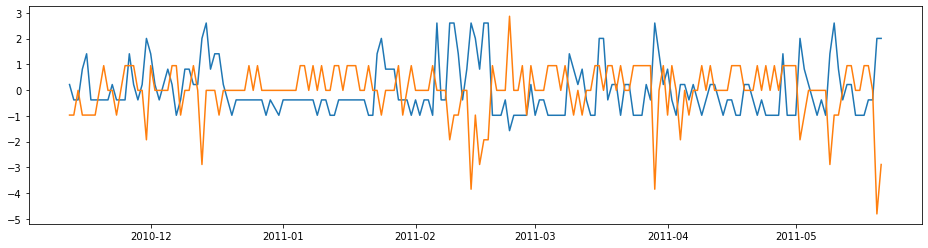

In [70]:
plt.figure(figsize=(16, 4))
plt.plot(ema_std["stress"])
plt.plot(ema_std["happy"])
plt.show()

## Rolling average of standardized data

In [71]:
ema_std_rolling = ema_std.rolling(3, axis=0).mean().dropna()

In [72]:
w = np.array([0.1, 0.2, 0.3, 0.4])
ema_weighted_rolling = ema_std.rolling(4).apply(lambda x: np.sum(w*x))

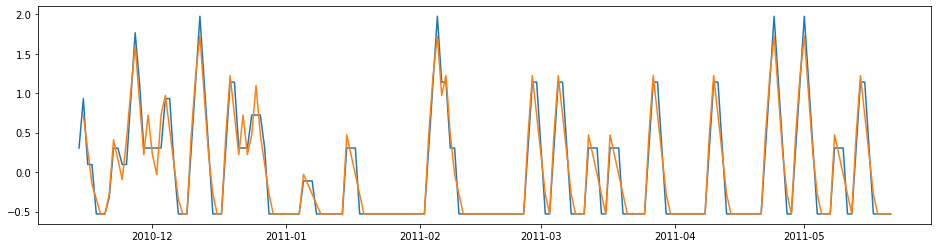

In [73]:
plt.figure(figsize=(16, 4))
plt.plot(ema_std_rolling["social_h"])
#plt.plot(ema_std_rolling["productive"])
plt.plot(ema_weighted_rolling["social_h"])
plt.show()

## Removing weekday trend

In [74]:
ema_trendless = ema_std.groupby(ema_std.index.weekday).apply(lambda x: x - x.median())

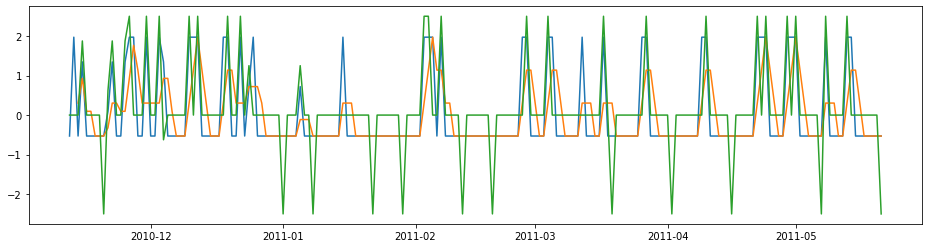

In [75]:
plt.figure(figsize=(16, 4))
plt.plot(ema_std["social_h"])
plt.plot(ema_std_rolling["social_h"])
plt.plot(ema_trendless["social_h"])
plt.show()

In [76]:
savgol = signal.savgol_filter(ema["stress"].fillna(method="ffill"), window_length=21, polyorder=3, mode="nearest")

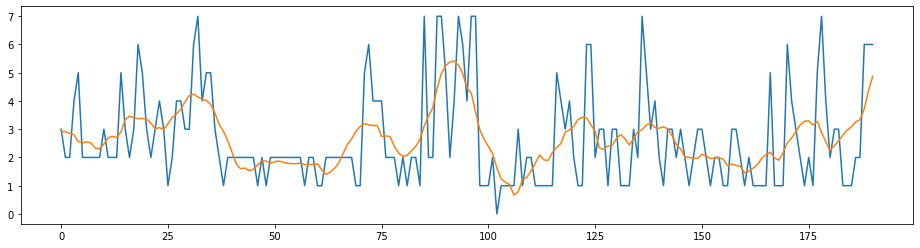

In [77]:
plt.figure(figsize=(16, 4))
plt.plot(ema["stress"].fillna(method="ffill").values)
plt.plot(savgol)
plt.show()

# Covariance coefficients

Text(0.5, 1.0, 'Correlation Matrix of EMA Z-Scores')

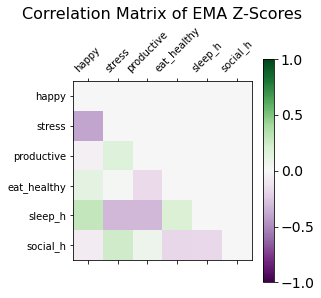

In [18]:
plt.matshow(np.tril(ema.corr(), k=-1), cmap="PRGn", vmin=-1, vmax=1)

plt.xticks(range(ema_std.shape[1]), ema_std.columns, rotation=45)
plt.yticks(range(ema_std.shape[1]), ema_std.columns)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

plt.title('Correlation Matrix of EMA Z-Scores', fontsize=16)

## L2 norm
quantifies the difference between standardized and rolling scores

Text(0.5, 1.0, 'L2 Norm of EMA covariance and their rolling average')

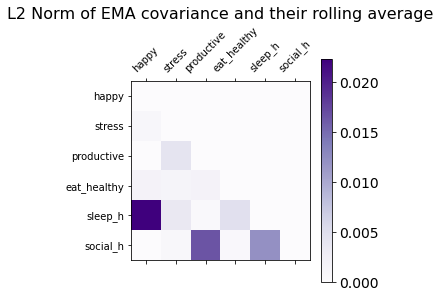

In [19]:
ema_norm = (ema_trendless.corr() - ema_std_rolling.corr())**2

plt.matshow(np.tril(ema_norm, k=-1), cmap="Purples", vmin=0)

plt.xticks(range(ema_std.shape[1]), ema_std.columns, rotation=45)
plt.yticks(range(ema_std.shape[1]), ema_std.columns)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

plt.title('L2 Norm of EMA covariance and their rolling average', fontsize=16)

# Routine for all users

In [34]:
def lower_tri_coefs(matrix):
    m = matrix.shape[0]
    row, col = np.triu_indices(m, k=1)
    return matrix.values[row, col]

In [35]:
user_covr = {}
user_rolling_covr = {}

for userid in USERIDS:
    user_df = _get_feature("DailyEMA", userid)
    if user_df.empty:
        continue
    
    user_df = user_df.sort_values("ema_date").drop_duplicates("ema_date", keep="last")
    user_df["ema_date"] = pd.to_datetime(user_df["ema_date"])
    user_df = user_df.set_index("ema_date")
    user_df = user_df.drop(columns=["userid"])
    
    ema_std = user_df.dropna().apply(stats.zscore, axis=0)
    ema_std_rolling = ema_std.rolling(7, axis=0).mean().dropna()
    
    ema_covr = ema_std.corr()
    user_covr[userid] = lower_tri_coefs(ema_covr)
    
    ema_rolling_covr = ema_std_rolling.corr()
    user_rolling_covr[userid] = lower_tri_coefs(ema_rolling_covr)
    

In [36]:
coefs_df = pd.DataFrame.from_dict(user_covr, orient="index")
rolling_coefs_df = pd.DataFrame.from_dict(user_rolling_covr, orient="index")

(<Figure size 432x288 with 16 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>])

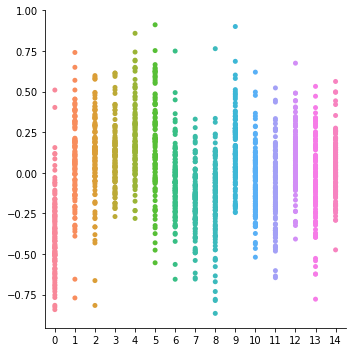

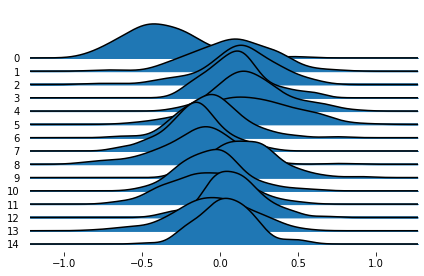

In [42]:
sns.catplot(data=coefs_df, jitter=False)
joypy.joyplot(coefs_df)

(<Figure size 432x288 with 16 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>])

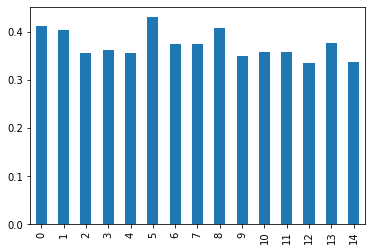

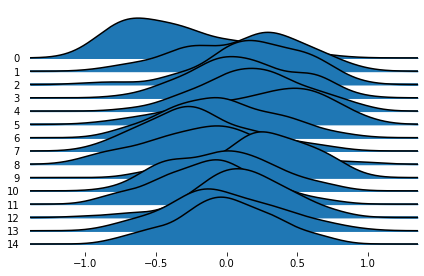

In [24]:
rolling_coefs_df.std().plot(kind="bar")
joypy.joyplot(rolling_coefs_df)

(<Figure size 432x288 with 16 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>])

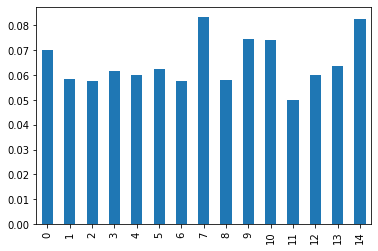

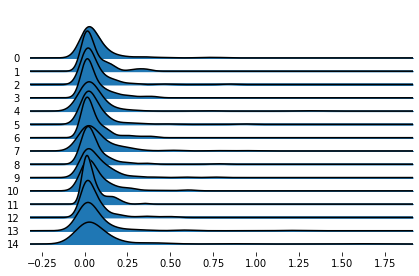

In [25]:
l2_df = (coefs_df - rolling_coefs_df)**2
l2_df.mean().plot(kind="bar")
joypy.joyplot(l2_df)